# FIR low-pass filter design on quaternion-weighted graph

This example performs a task similar to the `lms.ipynb` notebook. Here
we reconstruct a quaternion-valued graph signal from its noisy version,
by means of a low-pass quaternion filter design via Quaternion Least Mean Squares (QLMS).

In [1]:
# If gspx is not installed, we add it to the path
import os, sys
gdir = os.path.dirname(os.getcwd())  # parent folder
sys.path.insert(0, gdir)

In [2]:
import numpy as np

from gspx.utils.display import plot_graph
from gspx.datasets import WeatherGraphData, uk_weather
from gspx.signals import QuaternionSignal
from gspx.qgsp import create_quaternion_weights, QGFT, QMatrix

## Quaternion-weighted graph

In [3]:
uk_data = WeatherGraphData()
Ar, coords = uk_data.graph
s = uk_data.signal

In [4]:
df = uk_weather()

Aq = create_quaternion_weights(
    Ar, df, icols=['humidity'], jcols=['temp'],
    kcols=['wind_speed'], gauss_den=0.5)

100%|██████████| 2014/2014 [00:09<00:00, 221.47it/s]


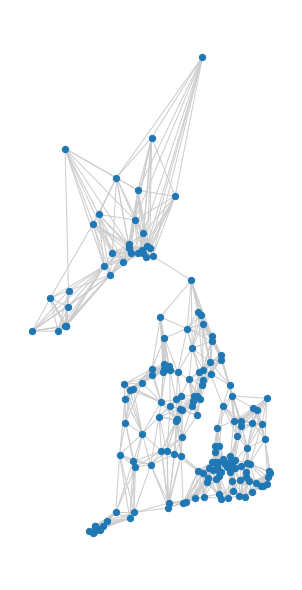

In [5]:
plot_graph(
    Aq.abs(), coords=coords,
    figsize=(4, 8), colormap='viridis',
    node_size=40)

In [6]:
qgft = QGFT()
qgft.fit(Aq)

Running eigendecomposition of the shift operator.
Sorting the frequencies based on Total Variation.


## Creating a quaternionic heat kernel (smooth signal)

In [7]:
# Heat kernel in all 4 quaternion dimensions
k = 0.2
ss = np.zeros(len(qgft.idx_freq))
ss[qgft.idx_freq] = np.exp(-k * np.arange(len(qgft.idx_freq)))

ss = QuaternionSignal.from_rectangular(
    np.hstack([ss[:, np.newaxis]] * 4)
)

In [8]:
rnd = np.random.default_rng(seed=42)
err_amplitude = 0.15

nn = QuaternionSignal.from_equal_dimensions(
    rnd.uniform(low=-err_amplitude, high=err_amplitude, size=len(ss))
)

Spectrum of the original smooth signal:

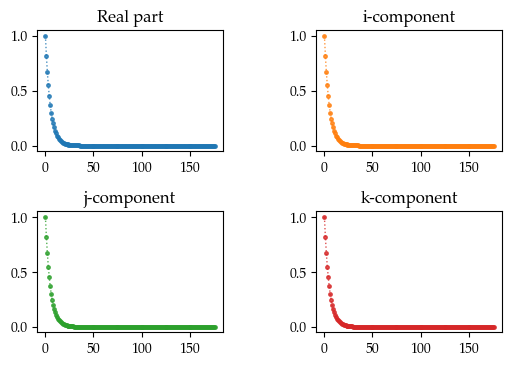

In [9]:
QuaternionSignal.show(ss, ordering=qgft.idx_freq)

Noisy version of the grash signal signal (in the frequency domain):

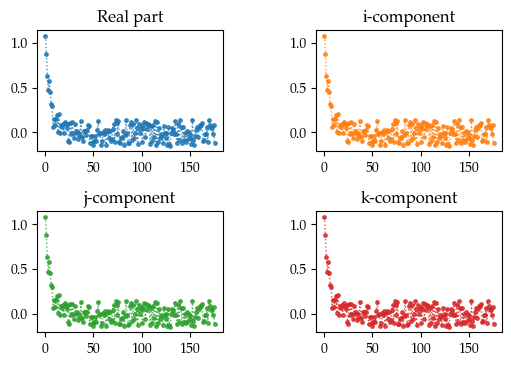

In [10]:
QuaternionSignal.show(ss + nn, ordering=qgft.idx_freq)

Original signal in the vertex domain:

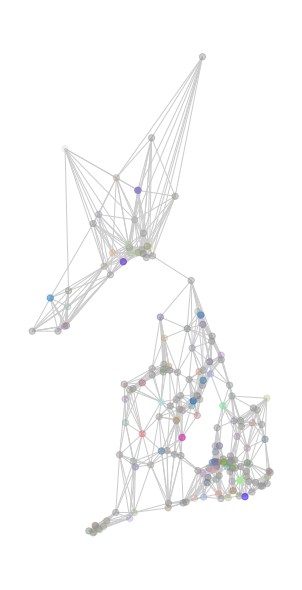

In [11]:
s = qgft.inverse_transform(ss)

obj = QuaternionSignal.from_samples(s.matrix.ravel())
node_color = [tuple(rgba) for rgba in obj.to_rgba()]

plot_graph(
    Aq.abs(), coords=coords, colors=node_color,
    figsize=(4, 8), colormap='viridis',
    node_size=40)

### Total variation of eigenvectors for each eigenvalue

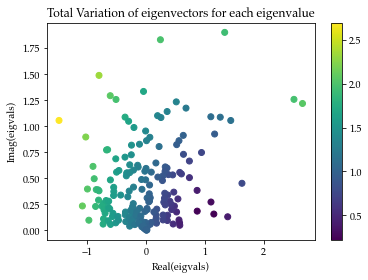

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.real(qgft.eigc), np.imag(qgft.eigc), c=qgft.tv_)
plt.colorbar()
plt.title("Total Variation of eigenvectors for each eigenvalue")
plt.xlabel("Real(eigvals)")
plt.ylabel("Imag(eigvals)")
plt.show()

### Ideal low-pass filter frequency response

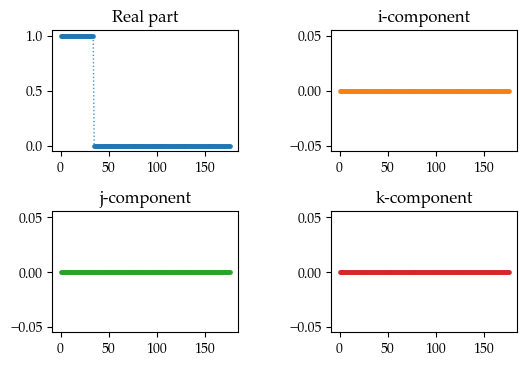

In [13]:
h_ideal = np.zeros(len(qgft.idx_freq))

# Bandwith of 20% the frequency support
bandwidth = int(len(qgft.idx_freq) / 5)
h_ideal[qgft.idx_freq[:bandwidth]] = 1

h_idealq = QuaternionSignal.from_rectangular(np.hstack((
    h_ideal[:, np.newaxis],
    np.zeros(len(qgft.idx_freq))[:, np.newaxis],
    np.zeros(len(qgft.idx_freq))[:, np.newaxis],
    np.zeros(len(qgft.idx_freq))[:, np.newaxis]
)))
QuaternionSignal.show(h_idealq, ordering=qgft.idx_freq)

## Low-pass filter design via QLMS

In [14]:
from gspx.qgsp import QMatrix
deg = 7

X = QMatrix.vander(qgft.eigq, deg, increasing=True)
y = h_idealq
print(X.shape, y.shape)

(177, 7) (177, 1)


LR: 0.4:  24%|██▍       | 24/100 [00:10<00:32,  2.37it/s]


Early stopping due to increasing cost in the last 10 iterations.


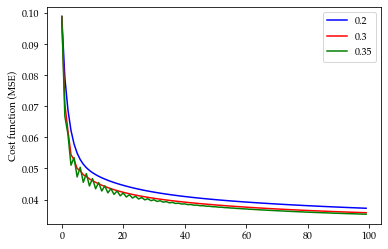

In [20]:
from gspx.adaptive import QLMS

qlms = QLMS(alpha=[0.2, 0.3, 0.35, 0.4])
qlms.fit(X, y)
qlms.plot(nsamples=100)

### Quaternion-valued filter taps

In [21]:
qlms.res_[qlms.best_lr_]['result']

Quaternion-valued array of shape (8, 1):
[[Quaternion(0.1977401129943503, -6.322626038543263e-17, 0.0, 0.0)]
 [Quaternion(0.0, 0.0, 0.0, 0.0)]
 [Quaternion(0.24163186305666126, -0.04822727559507493, 0.0, 0.0)]
 [Quaternion(0.16189199366089266, 0.22310677197502723, 0.0, 0.0)]
 [Quaternion(-0.08943835242101406, 0.12157280581138728, 0.0, 0.0)]
 [Quaternion(-0.001981449827164567, 0.13344729986966034, 0.0, 0.0)]
 [Quaternion(-0.04205244388345501, 0.023227514188983136, 0.0, 0.0)]
 [Quaternion(-0.15350470814085504, 0.025991555601035495, 0.0, 0.0)]]

### FIR filter response

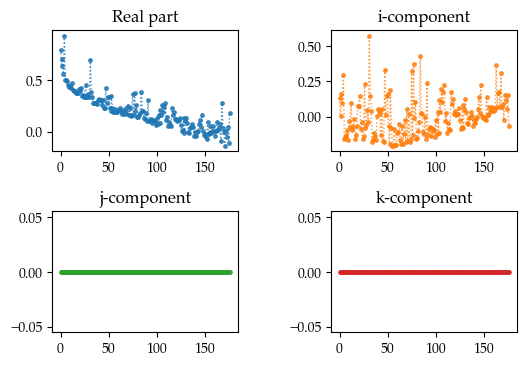

In [22]:
h_opt = qlms.predict(X)
h_opt = QuaternionSignal.from_samples(h_opt.matrix.ravel())
QuaternionSignal.show(h_opt, ordering=qgft.idx_freq)

### Signal reconstruction using both the ideal and the FIR low-pass filters

Ideal LPF filter.
MSE prior (* 1000): 27.53187194608166
MSE post (* 1000): 3.8673396913153173


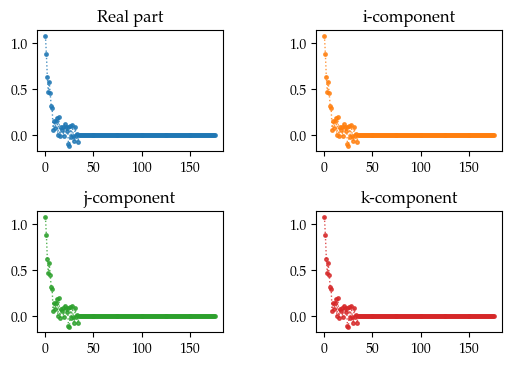

In [23]:
print("Ideal LPF filter.")
sn = qgft.inverse_transform(ss + nn)

print("MSE prior (* 1000):", 1000 * np.mean((s - sn).abs()**2))

ssn_lpf = (ss + nn).hadamard(h_idealq)
s_lpf = qgft.inverse_transform(ssn_lpf)

print("MSE post (* 1000):", 1000 * np.mean((s - s_lpf).abs()**2))

QuaternionSignal.show(ssn_lpf, ordering=qgft.idx_freq)

FIR LPF filter.
MSE prior (* 1000): 27.53187194608166
MSE post (* 1000): 14.23732986589735


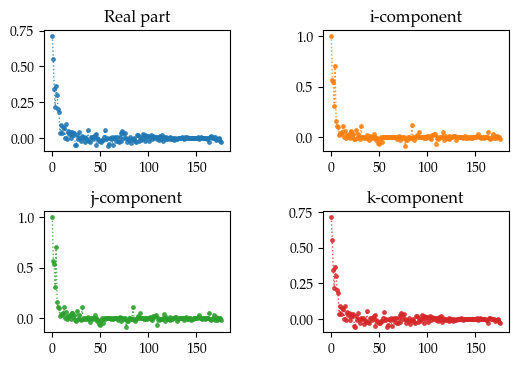

In [24]:
print("FIR LPF filter.")
sn = qgft.inverse_transform(ss + nn)

print("MSE prior (* 1000):", 1000 * np.mean((s - sn).abs()**2))

ssn_lpf = (ss + nn).hadamard(h_opt)
s_lpf = qgft.inverse_transform(ssn_lpf)

print("MSE post (* 1000):", 1000 * np.mean((s - s_lpf).abs()**2))

QuaternionSignal.show(ssn_lpf, ordering=qgft.idx_freq)